# Implementation of a Devito acoustic Least-square Reverse time migration

## This tutorial is contributed by SENAI CIMATEC (2021)

This tutorial is based on:

<br>**LEAST-SQUARES REVERSE TIME MIGRATION (LSRTM) IN THE SHOT DOMAIN** (2016)
<br>Antonio Edson Lima de Oliveira, Reynam da Cruz Pestana and Adriano Wagner Gomes dos Santos
<br>Brazilian Journal of Geopyisics
<br>http://dx.doi.org/10.22564/rbgf.v34i3.831

<br>**Plane-wave least-squares reverse-time migration** (2013)
<br>Wei Dai and Gerard T. Schuster
<br>GEOPHYSICS Technical Papers 
<br>http://dx.doi.org/10.22564/rbgf.v34i3.831

## Introduction 
The goal of this tutorial is to implement and validate the Least-squares reverse time migration (LSRTM) using a 2D two-layered velocity model. The algorithm has been implemented using the Born's appoximation.

For Born's implementation, a perturbation in the velocity field $v \approx v_{0} + \delta v$ produces an incident wavefield ( $p_{0}$ ) and scattered wavefield ( $\delta p$ ), so the wavefield $p$ is approximated to $ p \approx p_0 + \delta p$.

Combining this approximation with the Taylor expansion into the constant-density acoustic wave equation,

\begin{equation}
 \dfrac{1}{v^2_0} \dfrac{\partial^2 p_0}{\partial t^2} - \nabla^2 p_0 = s (\mathbf{x},t)   \hspace{0.5cm}     (1)
\end{equation}

\begin{equation}
\dfrac{1}{v^2_0} \dfrac{\partial^2 \delta p}{\partial t^2} - \nabla^2 \delta p = \dfrac{2\delta v}{v^3_{0}} \dfrac{\partial^2 p_0}{\partial t^2}  \hspace{0.5cm}    (2)
\end{equation}

 Equations (1) and (2) are for Born modelling. The Born reverse modelling is defined by the equation:
 
 \begin{equation}
\dfrac{1}{v^2_0} \dfrac{\partial^2 q}{\partial t^2} - \nabla^2 q =\textbf{d}  \hspace{0.5cm}     (3)
\end{equation}
where $\textbf{d}$ is the shot recorded.

With all these equations, the migrated image can be constructed

\begin{equation}
\mathbf{m}= \sum_{t} \dfrac{1}{v^2_0}\dfrac{\partial^2 p_0}{\partial t^2}q \hspace{0.5cm}     (4)
\end{equation}

The Least-square reverse time migration is an iterative method. After a first migration is done, the image is update iteratively

\begin{equation}
\textbf{m}_{k+1} = \textbf{m}_k -\alpha_k \textbf{g}_k \hspace{0.5cm}     (5)
\end{equation}
where $\textbf{g}_k$ is the gradient and $\alpha_k$ is the step-length. The gradient computation is simply taking equation (3) and instead of injecting the shot recorded $\textbf{d}$, injects the residue $\textbf{d}_{calc}-\textbf{d}_{obs}$

For now we are going to import the utilities.

In [1]:
%matplotlib inline
import numpy as np

from devito import Operator,Eq,solve,Grid,SparseFunction,norm
from devito import TimeFunction,Function
from devito import gaussian_smooth
from devito import mmax

from devito.logger import info
from devito.tools import memoized_meth

from examples.seismic import Model
from examples.seismic import plot_velocity, plot_perturbation
from examples.seismic import RickerSource,Receiver
from examples.seismic import PointSource
from examples.seismic import plot_image,AcquisitionGeometry
from examples.seismic import plot_shotrecord
from examples.seismic import TimeAxis

from examples.seismic.self_adjoint import (setup_w_over_q)
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic.acoustic.operators import (
    ForwardOperator, AdjointOperator, GradientOperator, BornOperator
)

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.ticker as plticker

# Seismic modelling with Devito

Now let's import all the parameters needed and create the true 2D velocity model and the smoothed model to perform the Born's modelling.

In [2]:
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define

fpeak = 0.010
t0w = 1.0 / fpeak
omega = 2.0 * np.pi * fpeak
qmin = 0.1
qmax = 100000
npad=50

nshots = 21
nreceivers = 101
t0 = 0.
tn = 1000.  # Simulation last 1 second (1000 ms)
f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
filter_sigma = (5, 5) # Filter's length

v = np.empty(shape, dtype=np.float32)
v[:, :51] = 1.5
v[:, 51:] = 2.5



init_damp = lambda func, nbl: setup_w_over_q(func, omega, qmin, qmax, npad, sigma=0)
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=8, bcs=init_damp,nbl=npad)
model0 = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=8, bcs=init_damp,nbl=npad)

dt = model.critical_dt 
s = model.grid.stepping_dim.spacing
time_range = TimeAxis(start=t0, stop=tn, step=dt)
nt=time_range.num

Operator `WOverQ_Operator` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `WOverQ_Operator` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s


Operator `smooth` ran in 0.01 s


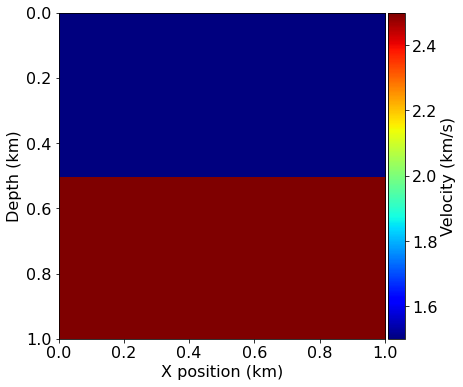

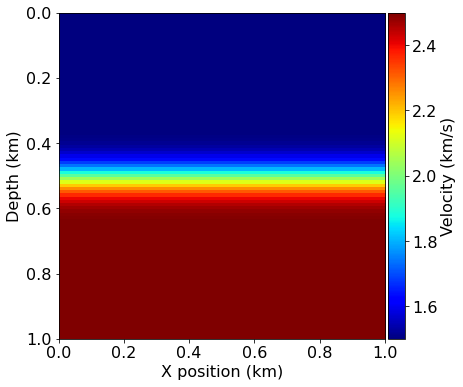

In [3]:
#NBVAL_IGNORE_OUTPUT
# Create initial model and smooth the boundaries
gaussian_smooth(model0.vp, sigma=filter_sigma)
# Plot the true and initial model and the perturbation between them
plot_velocity(model)
plot_velocity(model0)

Now we are going to set the source and receiver position.

In [4]:
# First, position source centrally in all dimensions, then set depth
src_coordinates = np.empty((1, 2))
src_coordinates[0, :] = np.array(model.domain_size) * .5
src_coordinates[0, -1] = 20.  # Depth is 20m


# Define acquisition geometry: receivers

# Initialize receivers for synthetic and imaging data
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 0] = np.linspace(0, model.domain_size[0], num=nreceivers)
rec_coordinates[:, 1] = 30.

# Geometry

geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=.010, src_type='Ricker')

solver = AcousticWaveSolver(model, geometry, space_order=8)

In [5]:
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = np.linspace(0., 1000, num=nshots)
source_locations[:, 1] = 30.

Now let's build the first migration Image.

In [6]:
def ImagingOperator(model, image):
    # Define the wavefield with the size of the model and the time dimension
    v = TimeFunction(name='v', grid=model.grid, time_order=2, space_order=8)

    u = TimeFunction(name='u', grid=model.grid, time_order=2, space_order=8,
                     save=geometry.nt)
    
    # Define the wave equation, but with a negated damping term
    eqn = model.m * v.dt2 - v.laplace + model.damp * v.dt.T

    # Use `solve` to rearrange the equation into a stencil expression
    stencil = Eq(v.backward, solve(eqn, v.backward))
    
    # Define residual injection at the location of the forward receivers
    dt = model.critical_dt
    residual = PointSource(name='residual', grid=model.grid,
                           time_range=geometry.time_axis,
                           coordinates=geometry.rec_positions)    
    res_term = residual.inject(field=v.backward, expr=residual * dt**2 / model.m)

    # Correlate u and v for the current time step and add it to the image
    image_update = Eq(image, image - u * v)

    return Operator([stencil] + res_term + [image_update],
                    subs=model.spacing_map)

In [7]:
#NBVAL_IGNORE_OUTPUT
# Run imaging loop over shots

# Create image symbol and instantiate the previously defined imaging operator
image = Function(name='image', grid=model.grid)
op_imaging = ImagingOperator(model, image)
for i in range(nshots):
    print('Observed data %d out of %d' % (i+1, nshots))
    geometry.src_positions[0, :] = source_locations[i, :]

    true_d , _, _ = solver.forward(vp=model.vp)
      
    print('Calculated data %d out of %d' % (i+1, nshots))
    smooth_d, _, _ = solver.forward(vp=model0.vp, save=True)
    
    _, u0, _ = solver.forward(vp=model0.vp, save=True)
    
    print('Imaging condition %d out of %d' % (i+1, nshots))
    v = TimeFunction(name='v', grid=model.grid, time_order=2, space_order=8)
    residual = smooth_d.data - true_d.data
    op_imaging(u=u0, v=v, vp=model0.vp, dt=model0.critical_dt, 
               residual=residual)

Observed data 1 out of 21


Operator `Forward` ran in 0.05 s


Calculated data 1 out of 21


Operator `Forward` ran in 0.05 s
Operator `Forward` ran in 0.04 s
Operator `Kernel` ran in 0.06 s
Operator `Forward` ran in 0.04 s


Imaging condition 1 out of 21
Observed data 2 out of 21
Calculated data 2 out of 21


Operator `Forward` ran in 0.04 s
Operator `Forward` ran in 0.04 s
Operator `Kernel` ran in 0.04 s
Operator `Forward` ran in 0.04 s
Operator `Forward` ran in 0.04 s


Imaging condition 2 out of 21
Observed data 3 out of 21
Calculated data 3 out of 21


Operator `Forward` ran in 0.04 s
Operator `Kernel` ran in 0.06 s
Operator `Forward` ran in 0.04 s


Imaging condition 3 out of 21
Observed data 4 out of 21
Calculated data 4 out of 21


Operator `Forward` ran in 0.05 s
Operator `Forward` ran in 0.05 s
Operator `Kernel` ran in 0.06 s
Operator `Forward` ran in 0.04 s


Imaging condition 4 out of 21
Observed data 5 out of 21
Calculated data 5 out of 21


Operator `Forward` ran in 0.05 s
Operator `Forward` ran in 0.05 s
Operator `Kernel` ran in 0.06 s
Operator `Forward` ran in 0.04 s


Imaging condition 5 out of 21
Observed data 6 out of 21
Calculated data 6 out of 21


Operator `Forward` ran in 0.05 s
Operator `Forward` ran in 0.05 s
Operator `Kernel` ran in 0.06 s
Operator `Forward` ran in 0.04 s


Imaging condition 6 out of 21
Observed data 7 out of 21
Calculated data 7 out of 21


Operator `Forward` ran in 0.05 s
Operator `Forward` ran in 0.05 s
Operator `Kernel` ran in 0.06 s
Operator `Forward` ran in 0.05 s


Imaging condition 7 out of 21
Observed data 8 out of 21
Calculated data 8 out of 21


Operator `Forward` ran in 0.05 s
Operator `Forward` ran in 0.06 s
Operator `Kernel` ran in 0.08 s
Operator `Forward` ran in 0.06 s


Imaging condition 8 out of 21
Observed data 9 out of 21
Calculated data 9 out of 21


Operator `Forward` ran in 0.05 s
Operator `Forward` ran in 0.06 s
Operator `Kernel` ran in 0.07 s
Operator `Forward` ran in 0.05 s


Imaging condition 9 out of 21
Observed data 10 out of 21
Calculated data 10 out of 21


Operator `Forward` ran in 0.05 s
Operator `Forward` ran in 0.04 s
Operator `Kernel` ran in 0.06 s
Operator `Forward` ran in 0.05 s


Imaging condition 10 out of 21
Observed data 11 out of 21
Calculated data 11 out of 21


Operator `Forward` ran in 0.05 s
Operator `Forward` ran in 0.05 s
Operator `Kernel` ran in 0.05 s
Operator `Forward` ran in 0.05 s


Imaging condition 11 out of 21
Observed data 12 out of 21
Calculated data 12 out of 21


Operator `Forward` ran in 0.05 s
Operator `Forward` ran in 0.04 s
Operator `Kernel` ran in 0.05 s
Operator `Forward` ran in 0.05 s


Imaging condition 12 out of 21
Observed data 13 out of 21
Calculated data 13 out of 21


Operator `Forward` ran in 0.06 s
Operator `Forward` ran in 0.05 s
Operator `Kernel` ran in 0.05 s
Operator `Forward` ran in 0.05 s


Imaging condition 13 out of 21
Observed data 14 out of 21
Calculated data 14 out of 21


Operator `Forward` ran in 0.04 s
Operator `Forward` ran in 0.04 s
Operator `Kernel` ran in 0.05 s
Operator `Forward` ran in 0.04 s


Imaging condition 14 out of 21
Observed data 15 out of 21
Calculated data 15 out of 21


Operator `Forward` ran in 0.05 s
Operator `Forward` ran in 0.04 s
Operator `Kernel` ran in 0.05 s
Operator `Forward` ran in 0.04 s
Operator `Forward` ran in 0.04 s


Imaging condition 15 out of 21
Observed data 16 out of 21
Calculated data 16 out of 21


Operator `Forward` ran in 0.04 s
Operator `Kernel` ran in 0.05 s
Operator `Forward` ran in 0.04 s
Operator `Forward` ran in 0.04 s


Imaging condition 16 out of 21
Observed data 17 out of 21
Calculated data 17 out of 21


Operator `Forward` ran in 0.04 s
Operator `Kernel` ran in 0.05 s
Operator `Forward` ran in 0.04 s


Imaging condition 17 out of 21
Observed data 18 out of 21
Calculated data 18 out of 21


Operator `Forward` ran in 0.05 s
Operator `Forward` ran in 0.07 s
Operator `Kernel` ran in 0.06 s
Operator `Forward` ran in 0.05 s


Imaging condition 18 out of 21
Observed data 19 out of 21
Calculated data 19 out of 21


Operator `Forward` ran in 0.04 s
Operator `Forward` ran in 0.04 s
Operator `Kernel` ran in 0.04 s
Operator `Forward` ran in 0.04 s


Imaging condition 19 out of 21
Observed data 20 out of 21
Calculated data 20 out of 21


Operator `Forward` ran in 0.04 s
Operator `Forward` ran in 0.04 s
Operator `Kernel` ran in 0.04 s
Operator `Forward` ran in 0.04 s
Operator `Forward` ran in 0.04 s


Imaging condition 20 out of 21
Observed data 21 out of 21
Calculated data 21 out of 21


Operator `Forward` ran in 0.05 s
Operator `Kernel` ran in 0.06 s


Imaging condition 21 out of 21


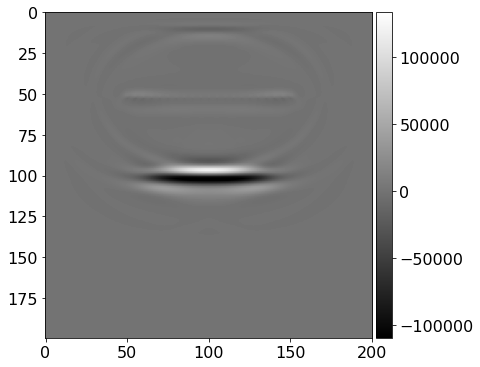

In [8]:
#NBVAL_IGNORE_OUTPUT
# Plot the inverted image
plot_image(np.diff(image.data, axis=1))

In [9]:
def plot_image_mask(data, vmin=None, vmax=None, colorbar=True, cmap="jet"):
    """
    Plot image data, such as RTM images or FWI gradients.

    Parameters
    ----------
    data : ndarray
        Image data to plot.
    cmap : str
        Choice of colormap. Defaults to gray scale for images as a
        seismic convention.
    """
    plot = plt.imshow(np.transpose(data),
                      vmin= np.min(data),
                      vmax= np.max(data),
                      cmap=cmap)

    # Create aligned colorbar on the right
    if colorbar:
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(plot, cax=cax)
    plt.show()

The Image migration has an artifact around sample #50, since Born's modelling uses the migration as a virtual source to compute the scattered field, the shot modelled will have an artifact, for that reason a 0-1 mask should be created to mute this part.

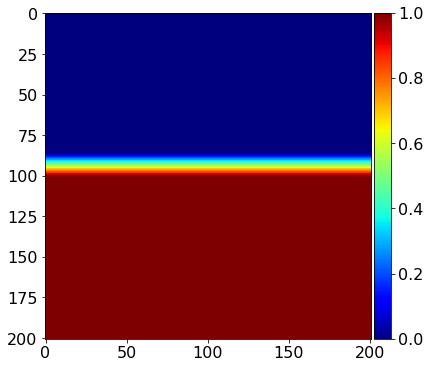

In [10]:
#NBVAL_IGNORE_OUTPUT
mask = Function(name='mask', grid=model.grid,space_order=0)
nztaper = 100
start=85
# the number of the taper samples are (nztaper-start)
for iz in range(nztaper):
    if iz <= start:
        mask.data[:,iz] = 1.
    else:
        mask.data[:,iz] = (1/(start+1-nztaper))*iz - nztaper*(1/(start+1-nztaper))
mask.data[:,:] = 1. - mask.data[:,:] 
plot_image_mask(mask.data)

Now we are going to perform the LSRTM.

In [11]:
#NBVAL_SKIP
image_up_dev = Function(name='image_up_dev', grid=model.grid)
nrec=101
niter=20 # number of iterations of the LSRTM
history = np.zeros((niter, 1)) #objective function
alfa_history = np.zeros((niter, 1)) # step-length
history_norm = np.zeros((niter, 1)) # normalized objective function
residual_niter = np.zeros((niter, 1))

grid_iter = Grid(shape=(niter,geometry.nt, model.shape[1]))

residual_k = Function(name='residual_k', grid=grid_iter)

for k in range(niter) :
    
    grad_full = Function(name='grad_full', grid=model.grid)
    
    residual = Receiver(name='residual', grid=model.grid, time_range=geometry.time_axis,
                   coordinates=geometry.rec_positions)
    
    residual_num = Receiver(name='residual_num', grid=model.grid, time_range=geometry.time_axis,
                   coordinates=geometry.rec_positions)
          
    d_obs = Receiver(name='d_obs', grid=model.grid,
                         time_range=geometry.time_axis,
                         coordinates=geometry.rec_positions)

    d_syn = Receiver(name='d_syn', grid=model.grid,
                         time_range=geometry.time_axis,
                         coordinates=geometry.rec_positions)
    
    dm =  image_up_dev.data/((model0.vp.data)**3) 

    dm_true =  (solver.model.vp.data**(-2) - model0.vp.data**(-2)) # Using devito's reference of virtual source

    print('LSRTM ITERATION',k+1)
    objective = 0.
    for i in range(nshots):
      
        print('Observed data %d out of %d' % (i+1, nshots))
        geometry.src_positions[0, :] = source_locations[i, :]

        _, u0, _ = solver.forward(vp=model0.vp, save=True)
        
        _, _, _,_ = solver.jacobian(dm_true, vp=model0.vp, rec = d_obs)
  
        print('Calculated data %d out of %d' % (i+1, nshots))
          
        solver.jacobian(dm, vp=model0.vp, rec = d_syn)
        
        residual.data[:] = d_syn.data[:]- d_obs.data[:]
     
        grad_shot,_ = solver.gradient(rec=residual, u=u0, vp=model0.vp)
        grad_sum = Eq(grad_full, grad_full  + mask*grad_shot) # on the gradient we have to apply the mask on the gradient otherwise the inversion will become unstable
        op_grad = Operator([grad_sum])
        op_grad.apply()
        
        objective += .5*norm(residual)**2
        residual_k.data[k][:][:] += residual.data[:][:]
              
    history[k] = objective
    residual_num.data[:][:] = residual_k.data[k-1][:][:]-residual_k.data[k][:][:]
    history_norm[k] =norm(residual_num)**2/norm(residual_k)**2
    alfa = .05 / mmax(grad_full) # step-length computation
    alfa_history[k] = alfa

    image_sum_f = Eq(image_up_dev, image_up_dev - alfa*grad_full)
    op_im_up = Operator([image_sum_f])
    op_im_up.apply()
    if history_norm[k] <= 1*10e-8:
        break

Operator `Forward` ran in 0.04 s


LSRTM ITERATION 1
Observed data 1 out of 21


Operator `Born` ran in 0.08 s
Operator `Born` ran in 0.08 s


Calculated data 1 out of 21


Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 2 out of 21
Calculated data 2 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.07 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s
Operator `Born` ran in 0.09 s


Observed data 3 out of 21


Operator `Born` ran in 0.07 s
Operator `Gradient` ran in 0.07 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.07 s


Calculated data 3 out of 21
Observed data 4 out of 21
Calculated data 4 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 5 out of 21
Calculated data 5 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s
Operator `Born` ran in 0.08 s


Observed data 6 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.07 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.06 s


Calculated data 6 out of 21
Observed data 7 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 7 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 8 out of 21
Calculated data 8 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 9 out of 21
Calculated data 9 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.07 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 10 out of 21


Operator `Born` ran in 0.07 s
Operator `Born` ran in 0.07 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s


Calculated data 10 out of 21


Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.07 s


Observed data 11 out of 21
Calculated data 11 out of 21


Operator `Born` ran in 0.07 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.07 s


Observed data 12 out of 21
Calculated data 12 out of 21


Operator `Born` ran in 0.07 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 13 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.07 s


Calculated data 13 out of 21


Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.06 s


Observed data 14 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 14 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 15 out of 21
Calculated data 15 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 16 out of 21
Calculated data 16 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.07 s


Observed data 17 out of 21
Calculated data 17 out of 21


Operator `Born` ran in 0.07 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.07 s


Observed data 18 out of 21
Calculated data 18 out of 21


Operator `Born` ran in 0.07 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.07 s


Observed data 19 out of 21
Calculated data 19 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 20 out of 21
Calculated data 20 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.07 s


Observed data 21 out of 21
Calculated data 21 out of 21


Operator `Born` ran in 0.07 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


LSRTM ITERATION 2
Observed data 1 out of 21
Calculated data 1 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 2 out of 21


Operator `Born` ran in 0.07 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 2 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 3 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 3 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 4 out of 21
Calculated data 4 out of 21


Operator `Born` ran in 0.07 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.07 s


Observed data 5 out of 21
Calculated data 5 out of 21


Operator `Born` ran in 0.07 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 6 out of 21
Calculated data 6 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s


Observed data 7 out of 21


Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.07 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 7 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.07 s


Observed data 8 out of 21
Calculated data 8 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 9 out of 21
Calculated data 9 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 10 out of 21
Calculated data 10 out of 21


Operator `Born` ran in 0.10 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 11 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 11 out of 21


Operator `Kernel` ran in 0.01 s


Observed data 12 out of 21


Operator `Forward` ran in 0.05 s
Operator `Born` ran in 0.08 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 12 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 13 out of 21
Calculated data 13 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 14 out of 21
Calculated data 14 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 15 out of 21
Calculated data 15 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 16 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.12 s


Calculated data 16 out of 21


Operator `Gradient` ran in 0.08 s
Operator `Kernel` ran in 0.01 s


Observed data 17 out of 21


Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 17 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 18 out of 21
Calculated data 18 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 19 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 19 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 20 out of 21
Calculated data 20 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 21 out of 21
Calculated data 21 out of 21


Operator `Born` ran in 0.10 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


LSRTM ITERATION 3
Observed data 1 out of 21
Calculated data 1 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 2 out of 21
Calculated data 2 out of 21


Operator `Born` ran in 0.07 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 3 out of 21
Calculated data 3 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.07 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.06 s


Observed data 4 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 4 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 5 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 5 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 6 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 6 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.06 s


Observed data 7 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.10 s


Calculated data 7 out of 21


Operator `Gradient` ran in 0.08 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 8 out of 21


Operator `Born` ran in 0.11 s
Operator `Born` ran in 0.10 s
Operator `Gradient` ran in 0.06 s


Calculated data 8 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 9 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 9 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 10 out of 21
Calculated data 10 out of 21


Operator `Born` ran in 0.10 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 11 out of 21
Calculated data 11 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 12 out of 21


Operator `Born` ran in 0.12 s
Operator `Born` ran in 0.12 s


Calculated data 12 out of 21


Operator `Gradient` ran in 0.08 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 13 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.10 s
Operator `Gradient` ran in 0.06 s


Calculated data 13 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 14 out of 21
Calculated data 14 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 15 out of 21
Calculated data 15 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 16 out of 21
Calculated data 16 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 17 out of 21
Calculated data 17 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 18 out of 21


Operator `Born` ran in 0.11 s
Operator `Born` ran in 0.11 s


Calculated data 18 out of 21


Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 19 out of 21
Calculated data 19 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 20 out of 21
Calculated data 20 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 21 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 21 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


LSRTM ITERATION 4
Observed data 1 out of 21


Operator `Born` ran in 0.11 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s


Calculated data 1 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 2 out of 21
Calculated data 2 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 3 out of 21
Calculated data 3 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 4 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.07 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s


Calculated data 4 out of 21


Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 5 out of 21
Calculated data 5 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 6 out of 21
Calculated data 6 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 7 out of 21
Calculated data 7 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 8 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 8 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 9 out of 21


Operator `Born` ran in 0.08 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 9 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 10 out of 21
Calculated data 10 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 11 out of 21
Calculated data 11 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 12 out of 21
Calculated data 12 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 13 out of 21
Calculated data 13 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 14 out of 21


Operator `Born` ran in 0.08 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 14 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 15 out of 21
Calculated data 15 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 16 out of 21
Calculated data 16 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 17 out of 21
Calculated data 17 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 18 out of 21
Calculated data 18 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 19 out of 21


Operator `Born` ran in 0.07 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 19 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 20 out of 21
Calculated data 20 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 21 out of 21
Calculated data 21 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


LSRTM ITERATION 5
Observed data 1 out of 21
Calculated data 1 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 2 out of 21


Operator `Born` ran in 0.08 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s


Calculated data 2 out of 21


Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 3 out of 21
Calculated data 3 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 4 out of 21
Calculated data 4 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 5 out of 21
Calculated data 5 out of 21


Operator `Born` ran in 0.10 s
Operator `Gradient` ran in 0.07 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 6 out of 21
Calculated data 6 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 7 out of 21


Operator `Born` ran in 0.11 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 7 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 8 out of 21
Calculated data 8 out of 21


Operator `Born` ran in 0.10 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 9 out of 21
Calculated data 9 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 10 out of 21
Calculated data 10 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 11 out of 21
Calculated data 11 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 12 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 12 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 13 out of 21
Calculated data 13 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 14 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.10 s


Calculated data 14 out of 21


Operator `Gradient` ran in 0.07 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 15 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.10 s
Operator `Gradient` ran in 0.06 s


Calculated data 15 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 16 out of 21
Calculated data 16 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 17 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 17 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 18 out of 21
Calculated data 18 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 19 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 19 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 20 out of 21
Calculated data 20 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 21 out of 21
Calculated data 21 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s


LSRTM ITERATION 6
Observed data 1 out of 21


Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.07 s
Operator `Born` ran in 0.07 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s


Calculated data 1 out of 21


Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 2 out of 21
Calculated data 2 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 3 out of 21
Calculated data 3 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 4 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.11 s


Calculated data 4 out of 21


Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 5 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.10 s


Calculated data 5 out of 21


Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 6 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.06 s


Calculated data 6 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 7 out of 21
Calculated data 7 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 8 out of 21
Calculated data 8 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 9 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Calculated data 9 out of 21
Observed data 10 out of 21
Calculated data 10 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 11 out of 21
Calculated data 11 out of 21


Operator `Born` ran in 0.10 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 12 out of 21
Calculated data 12 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 13 out of 21
Calculated data 13 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 14 out of 21
Calculated data 14 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 15 out of 21
Calculated data 15 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.06 s


Observed data 16 out of 21


Operator `Born` ran in 0.11 s
Operator `Born` ran in 0.11 s


Calculated data 16 out of 21


Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 17 out of 21
Calculated data 17 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 18 out of 21
Calculated data 18 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 19 out of 21
Calculated data 19 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 20 out of 21
Calculated data 20 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 21 out of 21
Calculated data 21 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


LSRTM ITERATION 7
Observed data 1 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 1 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 2 out of 21
Calculated data 2 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 3 out of 21
Calculated data 3 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s


Observed data 4 out of 21


Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s


Calculated data 4 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 5 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s


Calculated data 5 out of 21


Operator `Gradient` ran in 0.07 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 6 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 6 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 7 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.10 s
Operator `Gradient` ran in 0.06 s


Calculated data 7 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 8 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 8 out of 21


Operator `Kernel` ran in 0.01 s


Observed data 9 out of 21


Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.07 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 9 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 10 out of 21
Calculated data 10 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 11 out of 21
Calculated data 11 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 12 out of 21
Calculated data 12 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 13 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 13 out of 21


Operator `Kernel` ran in 0.01 s


Observed data 14 out of 21


Operator `Forward` ran in 0.05 s
Operator `Born` ran in 0.08 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 14 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 15 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.10 s
Operator `Gradient` ran in 0.06 s


Calculated data 15 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 16 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.06 s


Calculated data 16 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 17 out of 21


Operator `Born` ran in 0.08 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 17 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 18 out of 21
Calculated data 18 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s


Observed data 19 out of 21


Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.06 s


Calculated data 19 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 20 out of 21
Calculated data 20 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 21 out of 21
Calculated data 21 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


LSRTM ITERATION 8
Observed data 1 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.10 s


Calculated data 1 out of 21


Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 2 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 2 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s
Operator `Born` ran in 0.08 s


Observed data 3 out of 21
Calculated data 3 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 4 out of 21
Calculated data 4 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 5 out of 21
Calculated data 5 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 6 out of 21
Calculated data 6 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 7 out of 21
Calculated data 7 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 8 out of 21
Calculated data 8 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 9 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.07 s


Calculated data 9 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 10 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.10 s
Operator `Gradient` ran in 0.06 s


Calculated data 10 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 11 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Calculated data 11 out of 21
Observed data 12 out of 21
Calculated data 12 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 13 out of 21
Calculated data 13 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 14 out of 21
Calculated data 14 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 15 out of 21
Calculated data 15 out of 21


Operator `Born` ran in 0.11 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 16 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 16 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 17 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.10 s


Calculated data 17 out of 21


Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 18 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 18 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 19 out of 21
Calculated data 19 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 20 out of 21
Calculated data 20 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 21 out of 21
Calculated data 21 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s


LSRTM ITERATION 9
Observed data 1 out of 21


Operator `Forward` ran in 0.05 s
Operator `Born` ran in 0.08 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 1 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 2 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.10 s
Operator `Gradient` ran in 0.06 s


Calculated data 2 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 3 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.10 s
Operator `Gradient` ran in 0.06 s


Calculated data 3 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 4 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.10 s
Operator `Gradient` ran in 0.06 s


Calculated data 4 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 5 out of 21
Calculated data 5 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s


Observed data 6 out of 21


Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 6 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 7 out of 21
Calculated data 7 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 8 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s


Calculated data 8 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 9 out of 21
Calculated data 9 out of 21


Operator `Born` ran in 0.10 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 10 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 10 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 11 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.10 s
Operator `Gradient` ran in 0.06 s


Calculated data 11 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 12 out of 21
Calculated data 12 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 13 out of 21
Calculated data 13 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 14 out of 21
Calculated data 14 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 15 out of 21


Operator `Born` ran in 0.11 s
Operator `Born` ran in 0.15 s


Calculated data 15 out of 21


Operator `Gradient` ran in 0.07 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 16 out of 21


Operator `Born` ran in 0.08 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s


Calculated data 16 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 17 out of 21
Calculated data 17 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 18 out of 21
Calculated data 18 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 19 out of 21
Calculated data 19 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 20 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 20 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 21 out of 21


Operator `Born` ran in 0.08 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 21 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


LSRTM ITERATION 10
Observed data 1 out of 21
Calculated data 1 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 2 out of 21
Calculated data 2 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 3 out of 21
Calculated data 3 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 4 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.11 s


Calculated data 4 out of 21


Operator `Gradient` ran in 0.08 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 5 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.10 s


Calculated data 5 out of 21


Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.06 s


Observed data 6 out of 21


Operator `Born` ran in 0.13 s
Operator `Born` ran in 0.12 s


Calculated data 6 out of 21


Operator `Gradient` ran in 0.07 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 7 out of 21


Operator `Born` ran in 0.13 s
Operator `Born` ran in 0.13 s


Calculated data 7 out of 21


Operator `Gradient` ran in 0.07 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 8 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.11 s


Calculated data 8 out of 21


Operator `Gradient` ran in 0.08 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 9 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 9 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 10 out of 21
Calculated data 10 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 11 out of 21
Calculated data 11 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 12 out of 21
Calculated data 12 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 13 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.10 s
Operator `Gradient` ran in 0.06 s


Calculated data 13 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 14 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 14 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 15 out of 21
Calculated data 15 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 16 out of 21
Calculated data 16 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 17 out of 21
Calculated data 17 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 18 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s


Calculated data 18 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 19 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 19 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 20 out of 21
Calculated data 20 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 21 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.10 s


Calculated data 21 out of 21


Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


LSRTM ITERATION 11
Observed data 1 out of 21
Calculated data 1 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 2 out of 21
Calculated data 2 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.07 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 3 out of 21
Calculated data 3 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 4 out of 21
Calculated data 4 out of 21


Operator `Born` ran in 0.10 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 5 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.10 s
Operator `Gradient` ran in 0.06 s


Calculated data 5 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 6 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 6 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 7 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s


Calculated data 7 out of 21


Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 8 out of 21
Calculated data 8 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 9 out of 21
Calculated data 9 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 10 out of 21
Calculated data 10 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 11 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.07 s


Calculated data 11 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 12 out of 21
Calculated data 12 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 13 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.10 s
Operator `Gradient` ran in 0.06 s


Calculated data 13 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 14 out of 21


Operator `Born` ran in 0.08 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 14 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 15 out of 21
Calculated data 15 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 16 out of 21
Calculated data 16 out of 21


Operator `Born` ran in 0.11 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 17 out of 21
Calculated data 17 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 18 out of 21


Operator `Born` ran in 0.11 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 18 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 19 out of 21


Operator `Born` ran in 0.08 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 19 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 20 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.10 s
Operator `Gradient` ran in 0.07 s


Calculated data 20 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 21 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s


Calculated data 21 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


LSRTM ITERATION 12
Observed data 1 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 1 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.07 s


Observed data 2 out of 21
Calculated data 2 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 3 out of 21
Calculated data 3 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 4 out of 21
Calculated data 4 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 5 out of 21
Calculated data 5 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s


Observed data 6 out of 21


Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.07 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 6 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 7 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 7 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 8 out of 21
Calculated data 8 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 9 out of 21
Calculated data 9 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 10 out of 21
Calculated data 10 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s


Observed data 11 out of 21


Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 11 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 12 out of 21
Calculated data 12 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 13 out of 21
Calculated data 13 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s
Operator `Born` ran in 0.09 s


Observed data 14 out of 21
Calculated data 14 out of 21


Operator `Born` ran in 0.10 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 15 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 15 out of 21


Operator `Kernel` ran in 0.01 s


Observed data 16 out of 21


Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.07 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 16 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 17 out of 21
Calculated data 17 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 18 out of 21
Calculated data 18 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 19 out of 21
Calculated data 19 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 20 out of 21
Calculated data 20 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s


Observed data 21 out of 21


Operator `Forward` ran in 0.05 s
Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 21 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


LSRTM ITERATION 13
Observed data 1 out of 21
Calculated data 1 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 2 out of 21
Calculated data 2 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 3 out of 21
Calculated data 3 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 4 out of 21
Calculated data 4 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 5 out of 21
Calculated data 5 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 6 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s


Calculated data 6 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 7 out of 21
Calculated data 7 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 8 out of 21
Calculated data 8 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 9 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.08 s


Calculated data 9 out of 21


Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 10 out of 21
Calculated data 10 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 11 out of 21
Calculated data 11 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 12 out of 21
Calculated data 12 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 13 out of 21
Calculated data 13 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 14 out of 21
Calculated data 14 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 15 out of 21
Calculated data 15 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 16 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 16 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 17 out of 21
Calculated data 17 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 18 out of 21
Calculated data 18 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 19 out of 21


Operator `Born` ran in 0.10 s


Calculated data 19 out of 21


Operator `Born` ran in 0.10 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 20 out of 21


Operator `Born` ran in 0.11 s
Operator `Born` ran in 0.11 s


Calculated data 20 out of 21


Operator `Gradient` ran in 0.09 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.07 s


Observed data 21 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 21 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


LSRTM ITERATION 14
Observed data 1 out of 21


Operator `Born` ran in 0.11 s
Operator `Born` ran in 0.10 s


Calculated data 1 out of 21


Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 2 out of 21


Operator `Born` ran in 0.16 s
Operator `Born` ran in 0.14 s


Calculated data 2 out of 21


Operator `Gradient` ran in 0.10 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.06 s


Observed data 3 out of 21


Operator `Born` ran in 0.11 s
Operator `Born` ran in 0.10 s


Calculated data 3 out of 21


Operator `Gradient` ran in 0.08 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 4 out of 21


Operator `Born` ran in 0.12 s
Operator `Born` ran in 0.11 s


Calculated data 4 out of 21


Operator `Gradient` ran in 0.09 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.07 s


Observed data 5 out of 21


Operator `Born` ran in 0.15 s
Operator `Born` ran in 0.14 s


Calculated data 5 out of 21


Operator `Gradient` ran in 0.10 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.07 s


Observed data 6 out of 21


Operator `Born` ran in 0.15 s
Operator `Born` ran in 0.15 s


Calculated data 6 out of 21


Operator `Gradient` ran in 0.10 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.06 s


Observed data 7 out of 21


Operator `Born` ran in 0.11 s
Operator `Born` ran in 0.10 s


Calculated data 7 out of 21


Operator `Gradient` ran in 0.07 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.06 s


Observed data 8 out of 21


Operator `Born` ran in 0.12 s
Operator `Born` ran in 0.11 s


Calculated data 8 out of 21


Operator `Gradient` ran in 0.07 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.07 s


Observed data 9 out of 21


Operator `Born` ran in 0.15 s
Operator `Born` ran in 0.13 s


Calculated data 9 out of 21


Operator `Gradient` ran in 0.08 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.09 s


Observed data 10 out of 21


Operator `Born` ran in 0.14 s
Operator `Born` ran in 0.15 s


Calculated data 10 out of 21


Operator `Gradient` ran in 0.11 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.06 s


Observed data 11 out of 21


Operator `Born` ran in 0.13 s
Operator `Born` ran in 0.11 s


Calculated data 11 out of 21


Operator `Gradient` ran in 0.07 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.06 s


Observed data 12 out of 21


Operator `Born` ran in 0.12 s
Operator `Born` ran in 0.10 s


Calculated data 12 out of 21


Operator `Gradient` ran in 0.07 s
Operator `Kernel` ran in 0.01 s


Observed data 13 out of 21


Operator `Forward` ran in 0.08 s
Operator `Born` ran in 0.15 s
Operator `Born` ran in 0.16 s


Calculated data 13 out of 21


Operator `Gradient` ran in 0.11 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.06 s


Observed data 14 out of 21


Operator `Born` ran in 0.11 s
Operator `Born` ran in 0.11 s


Calculated data 14 out of 21


Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 15 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 15 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 16 out of 21
Calculated data 16 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 17 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s


Calculated data 17 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.06 s


Observed data 18 out of 21


Operator `Born` ran in 0.08 s
Operator `Born` ran in 0.07 s
Operator `Gradient` ran in 0.05 s


Calculated data 18 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.07 s


Observed data 19 out of 21
Calculated data 19 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 20 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.10 s
Operator `Gradient` ran in 0.06 s


Calculated data 20 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 21 out of 21
Calculated data 21 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


LSRTM ITERATION 15
Observed data 1 out of 21
Calculated data 1 out of 21


Operator `Born` ran in 0.11 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 2 out of 21
Calculated data 2 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 3 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 3 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 4 out of 21


Operator `Born` ran in 0.08 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 4 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.07 s


Observed data 5 out of 21
Calculated data 5 out of 21


Operator `Born` ran in 0.07 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 6 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 6 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 7 out of 21
Calculated data 7 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 8 out of 21
Calculated data 8 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 9 out of 21
Calculated data 9 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 10 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 10 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 11 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 11 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 12 out of 21
Calculated data 12 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 13 out of 21
Calculated data 13 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 14 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 14 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 15 out of 21
Calculated data 15 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 16 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 16 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 17 out of 21
Calculated data 17 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 18 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.10 s


Calculated data 18 out of 21


Operator `Gradient` ran in 0.08 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 19 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 19 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 20 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.10 s
Operator `Gradient` ran in 0.06 s


Calculated data 20 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 21 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.07 s
Operator `Gradient` ran in 0.05 s


Calculated data 21 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


LSRTM ITERATION 16
Observed data 1 out of 21
Calculated data 1 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 2 out of 21
Calculated data 2 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 3 out of 21
Calculated data 3 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 4 out of 21


Operator `Born` ran in 0.11 s
Operator `Born` ran in 0.13 s


Calculated data 4 out of 21


Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 5 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.07 s


Calculated data 5 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 6 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.07 s
Operator `Gradient` ran in 0.05 s


Calculated data 6 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 7 out of 21
Calculated data 7 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 8 out of 21
Calculated data 8 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 9 out of 21
Calculated data 9 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.07 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 10 out of 21
Calculated data 10 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.07 s


Observed data 11 out of 21
Calculated data 11 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 12 out of 21
Calculated data 12 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 13 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 13 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 14 out of 21


Operator `Born` ran in 0.09 s


Calculated data 14 out of 21


Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 15 out of 21
Calculated data 15 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 16 out of 21
Calculated data 16 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 17 out of 21
Calculated data 17 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 18 out of 21
Calculated data 18 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 19 out of 21


Operator `Born` ran in 0.11 s
Operator `Born` ran in 0.10 s


Calculated data 19 out of 21


Operator `Gradient` ran in 0.07 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.06 s


Observed data 20 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 20 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 21 out of 21
Calculated data 21 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.07 s


LSRTM ITERATION 17
Observed data 1 out of 21
Calculated data 1 out of 21


Operator `Born` ran in 0.07 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.06 s


Observed data 2 out of 21


Operator `Born` ran in 0.12 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s


Calculated data 2 out of 21


Operator `Kernel` ran in 0.01 s


Observed data 3 out of 21


Operator `Forward` ran in 0.07 s
Operator `Born` ran in 0.14 s
Operator `Born` ran in 0.11 s


Calculated data 3 out of 21


Operator `Gradient` ran in 0.09 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 4 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.10 s
Operator `Gradient` ran in 0.06 s


Calculated data 4 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 5 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.13 s


Calculated data 5 out of 21


Operator `Gradient` ran in 0.08 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 6 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 6 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.07 s


Observed data 7 out of 21
Calculated data 7 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s


Observed data 8 out of 21


Operator `Forward` ran in 0.05 s
Operator `Born` ran in 0.08 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.07 s


Calculated data 8 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 9 out of 21


Operator `Born` ran in 0.08 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 9 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 10 out of 21
Calculated data 10 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 11 out of 21
Calculated data 11 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 12 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s


Calculated data 12 out of 21


Operator `Kernel` ran in 0.01 s


Observed data 13 out of 21


Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.07 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 13 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 14 out of 21
Calculated data 14 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.07 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.06 s


Observed data 15 out of 21


Operator `Born` ran in 0.15 s
Operator `Born` ran in 0.09 s


Calculated data 15 out of 21


Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 16 out of 21


Operator `Born` ran in 0.08 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 16 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 17 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.06 s


Calculated data 17 out of 21


Operator `Kernel` ran in 0.01 s


Observed data 18 out of 21


Operator `Forward` ran in 0.05 s
Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.06 s


Calculated data 18 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 19 out of 21
Calculated data 19 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 20 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 20 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 21 out of 21


Operator `Born` ran in 0.12 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s


Calculated data 21 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


LSRTM ITERATION 18
Observed data 1 out of 21


Operator `Born` ran in 0.10 s


Calculated data 1 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 2 out of 21
Calculated data 2 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 3 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.10 s
Operator `Gradient` ran in 0.06 s


Calculated data 3 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 4 out of 21
Calculated data 4 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 5 out of 21
Calculated data 5 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 6 out of 21
Calculated data 6 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 7 out of 21


Operator `Born` ran in 0.08 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 7 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 8 out of 21
Calculated data 8 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 9 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 9 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.06 s


Observed data 10 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.10 s
Operator `Gradient` ran in 0.06 s


Calculated data 10 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 11 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 11 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 12 out of 21
Calculated data 12 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 13 out of 21
Calculated data 13 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 14 out of 21
Calculated data 14 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 15 out of 21
Calculated data 15 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 16 out of 21
Calculated data 16 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 17 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s


Calculated data 17 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 18 out of 21
Calculated data 18 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 19 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 19 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 20 out of 21
Calculated data 20 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 21 out of 21
Calculated data 21 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


LSRTM ITERATION 19
Observed data 1 out of 21
Calculated data 1 out of 21


Operator `Born` ran in 0.10 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 2 out of 21


Operator `Born` ran in 0.11 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 2 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 3 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 3 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 4 out of 21


Operator `Born` ran in 0.08 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.06 s


Calculated data 4 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 5 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.10 s
Operator `Gradient` ran in 0.06 s


Calculated data 5 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 6 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 6 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 7 out of 21
Calculated data 7 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 8 out of 21
Calculated data 8 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 9 out of 21
Calculated data 9 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 10 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 10 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 11 out of 21
Calculated data 11 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 12 out of 21
Calculated data 12 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 13 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 13 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 14 out of 21
Calculated data 14 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s


Observed data 15 out of 21


Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.07 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 15 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 16 out of 21
Calculated data 16 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 17 out of 21
Calculated data 17 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 18 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 18 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 19 out of 21
Calculated data 19 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 20 out of 21


Operator `Born` ran in 0.07 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 20 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 21 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 21 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.07 s


LSRTM ITERATION 20
Observed data 1 out of 21
Calculated data 1 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 2 out of 21
Calculated data 2 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 3 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 3 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 4 out of 21
Calculated data 4 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 5 out of 21
Calculated data 5 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 6 out of 21
Calculated data 6 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 7 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s


Calculated data 7 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 8 out of 21


Operator `Born` ran in 0.11 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 8 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 9 out of 21
Calculated data 9 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 10 out of 21
Calculated data 10 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.09 s


Observed data 11 out of 21
Calculated data 11 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 12 out of 21
Calculated data 12 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 13 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 13 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 14 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 14 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 15 out of 21
Calculated data 15 out of 21


Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 16 out of 21
Calculated data 16 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s
Operator `Born` ran in 0.08 s


Observed data 17 out of 21
Calculated data 17 out of 21


Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 18 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.05 s


Calculated data 18 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 19 out of 21


Operator `Born` ran in 0.09 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.06 s


Calculated data 19 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.04 s


Observed data 20 out of 21


Operator `Born` ran in 0.08 s
Operator `Born` ran in 0.08 s
Operator `Gradient` ran in 0.05 s


Calculated data 20 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.05 s


Observed data 21 out of 21


Operator `Born` ran in 0.10 s
Operator `Born` ran in 0.09 s
Operator `Gradient` ran in 0.06 s


Calculated data 21 out of 21


Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s


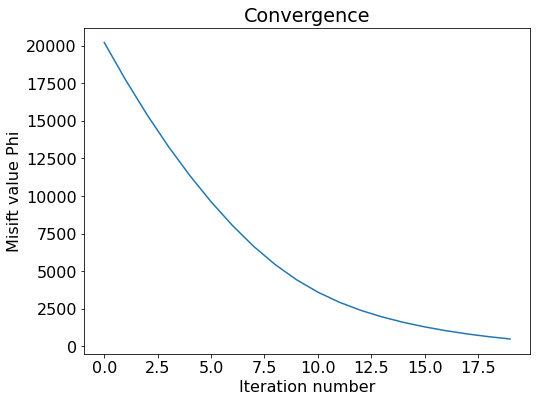

In [12]:
#NBVAL_SKIP
plt.figure()
plt.plot(history)
plt.xlabel('Iteration number')
plt.ylabel('Misift value Phi')
plt.title('Convergence')
plt.show()

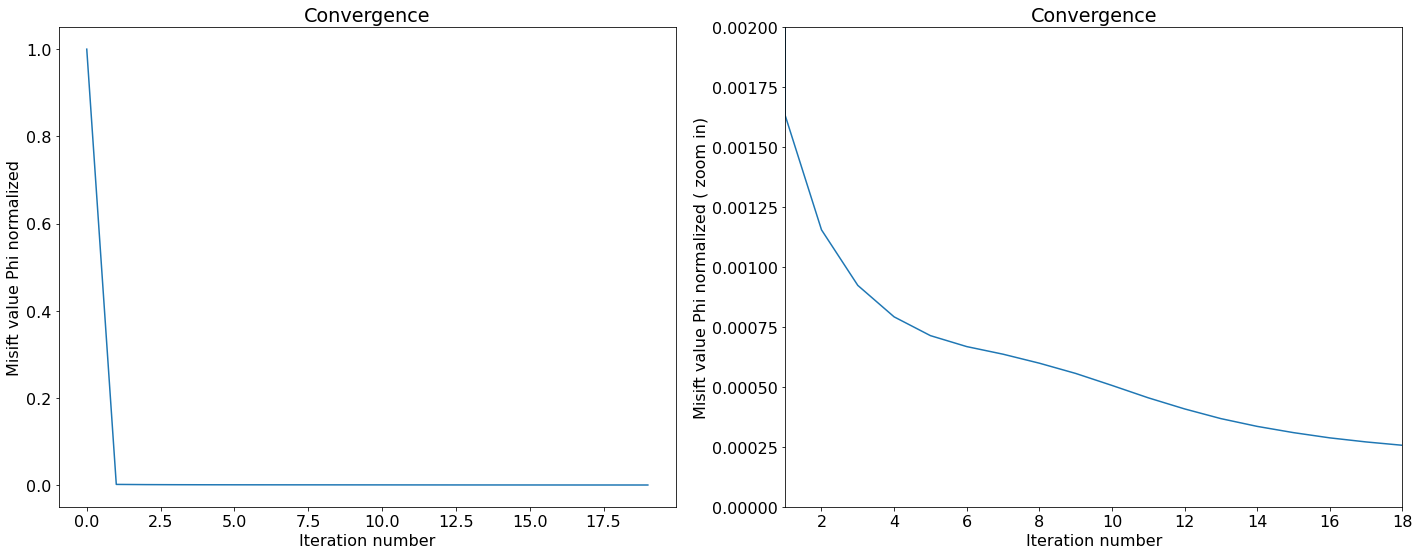

In [13]:
#NBVAL_SKIP
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.plot(history_norm)
plt.xlabel('Iteration number')
plt.ylabel('Misift value Phi normalized')
plt.title('Convergence')
plt.subplot(1, 2, 2)
plt.plot(history_norm)
plt.xlabel('Iteration number')
plt.ylabel('Misift value Phi normalized ( zoom in)')
plt.title('Convergence')
plt.xlim(1,18)
plt.ylim(0,0.002)
plt.tight_layout()
plt.show()

Now we have the first migration, and the reflector is not focused and still there is the backscaterring noise.

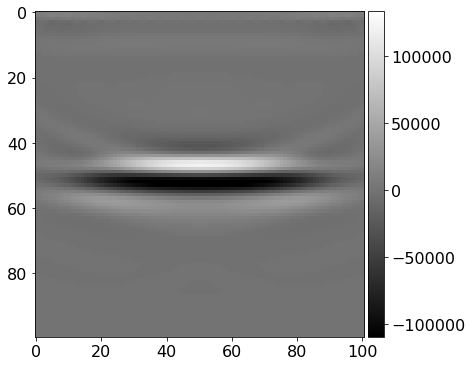

In [14]:
#NBVAL_IGNORE_OUTPUT
slices=tuple(slice(model.nbl,-model.nbl) for _ in range(2))
image_ori=image.data[slices]
plot_image(np.diff(image_ori.data, axis=1))

So here we have the LSRTM migration after 20 iterations, it is clear that the reflector is well focused and backscaterring noise has gone.

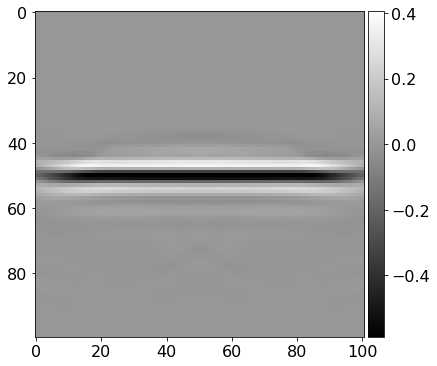

In [15]:
#NBVAL_SKIP
slices=tuple(slice(model.nbl,-model.nbl) for _ in range(2))
imagef=image_up_dev.data[slices]
plot_image(np.diff(imagef.data, axis=1))

Here we have the true reflectivity. The idea in showing it is to demonstrate that the amplitude range of the LSRTM is in the same amplitude range of the true reflectivity.

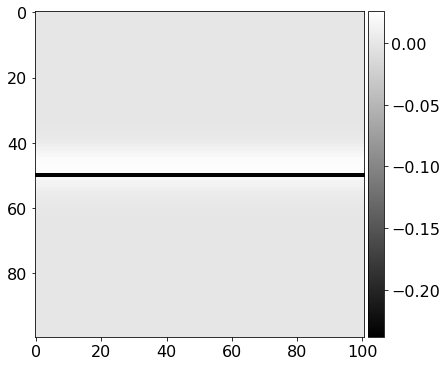

In [16]:
#NBVAL_IGNORE_OUTPUT
slices=tuple(slice(model.nbl,-model.nbl) for _ in range(2))
image_true=(solver.model.vp.data**(-2) - model0.vp.data**(-2))[slices]
plot_image(np.diff(image_true.data, axis=1))